# SENSitivity Encoding (SENSE)

SENSE is the primary **image-domain** parallel imaging methodology. This means it combines the images from the mulitple coils in image space after their reconstruction. This is its major distinction to frequency domain methods like GRAPPA which combine the signals from mulitple coils in K-space and then merges them.

## SENSE Algorithm

Each of the coils in parallel imaging are located in different parts of the scanner and therefore each coil has a different, non-uniform Field of View (FoV). SENSE uses sensitivity maps to encode these non-uniform FoVs. These maps are assumed to be smooth (only contain low frequency components).

<img src="pics/SENSEexample_maps.png">
  
### Sensitivity Map Calibration Methodologies
There are two methods for generating these sensitivity maps: a calibration scan or estimation from the actual scan. The former performs a low-resolution, calibration scan beforehand (since the maps are assumed to only contains low frequencies) to get the sensitivity maps. However, these additional calibration scans are time consuming and assume that the sensitivity maps remain unchanged between calibration and actual scan. The latter method estimates the sensitivity maps from the actual scan. For each coil, it:
   1. Fully samples center of K-space, partially samples rest
   2. Extracts low frequency components using a Kaiser-Bessel window
   3. Computes low-frequency image with inverse Fourier Transform
   4. Normalises low-frequency images with sum-of-squares image
 
### Image Reconstruction 
SENSE uses the MRI physical K-space data acquisition model:

$$y_i = FS_ix + \eta_i,    \forall i \in [1, C] \tag{1}$$

Where:
* $y_i$ is the K-space data from the $i$th coil
* $x$ is the image to be reconstructed
* $S_i$ is the diagonalised sensitivity profile
  * Take the sensitivity map image
  * Concatenate the rows to form a vector
  * Form diagonal matrix from this vector
* $F$ is the Fourier mapping from image space to K-space
* $\eta_i$ is the noise from the $i$th coil
* $C$ is the total number of coils

Refactoring this into vectors gives:

$$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_C \end{bmatrix} = \begin{bmatrix} FS_1 \\ FS_2 \\ \vdots \\ FS_C \end{bmatrix}x + \begin{bmatrix} \eta_1 \\ \eta_2 \\ \vdots \\ \eta_C \end{bmatrix} \tag{2}$$

$$y = Ex + \eta \tag{3}$$

Where $E$ is called the encoding operator.

From this we solve for the image, $x$, via conventional least-squares minimisation:

$$\hat{x} = \arg\min_x||y-Ex||_2^2 \tag{4}$$

The standard theoretical solution for least-squares minimisation of this form

$$\hat{x} = (E^TE)^{-1}E^Ty \tag{5}$$

In practise though this theoretical solution is often numerically unstable 

## Regularised SENSE Algorithm 
Conventional least squares minimisation tends to overfit and therefore regularisation is often employed. This changes the minimisation objective function to:

$$\hat{x} = \arg\min_x||y-Ex||_2^2 + \lambda Z(x) \tag{6}$$

Where:
* $\lambda$ is a scalar controlling the amount of regularisation
* $Z(x)$ is a function implementing some regularisation on $x$

Tikhonov regularization is a well-known technique but not used in practise

### Total Variation (TV) Regularisation
TV regularisation assumes piecewise linearity and hence a sparse image gradient. Therefore it adds a penalty for high image gradients: 

$$Z_{TV}(x) = \sum\sqrt{(D_hx)^2 + (D_vx)^2} \tag{7}$$

Where:
* $D_h$ is the horizontal differentiation operator
* $D_v$ is the vertical differentiation operator


#### Non-Local TV (NLTV) Regularisation 
TV Regularisation places equal weight on each derivative. Recently, the weights of the operators have been varied so as to not destroy salient features in the image. This has led to the non-local TV regularisation:

$$Z_{NLTV}(x) = \sum\sqrt{w(m,n)}(x_m-x_n) \tag{8}$$

Where:
* $m$, $n$ are two points in the image
* $w(m,n) = \frac{\tilde{w}(m,n)}{\sum\tilde{w}(m,n)}$
  * $\tilde{w}(m,n) = \exp(-\frac{1}{2\sigma^2}||p(m)-p(n)||_2^2)$ if $||m-n|| \le \tfrac{1}{2}\delta$ else $0$
    * $p(m)$ denotes the patch around $m$
    * $\delta$ controls the nonlocality (region of interest)
    * $\sigma$ controls the spread of the patch and is set depending on the noise level

## Iterative SENSE Algorithm 

Previous methodologies compute the sensitivity maps prior to reconstruction and therefore the reconstruction accuracy is directly linked to the sensitivity map accuracy. An alternative methodology was proposed in order to get a robust reconstruction. This method tries to jointly estimate the image and the sensitivity maps.
  
The Sensitivity map is modeled as an $N^{th}$ order polynomial:

$$S_{i,p,q}(a) = \sum_{p=0}^N\sum_{q=0}^Na_{i,p,q}x^py^q \tag{9}$$

Where:
* $i \in [1, C]$
* $p \in [1, \text{width}]$
* $q \in [1, \text{height}]$

This changes the original SENSE equation to 

$$y=FS(a)x + \eta \tag{10}$$

Where:
* $S(a) = \begin{bmatrix}S_1(a) \\ S_2(a) \\ \vdots \\ S_C(a) \end{bmatrix}$

This complicates the objective function; it is now an intractable non-convex problem:

$$\hat{x} = \arg\min_{a,x}||y-FS(a)x||_2^2 \tag{11}$$

To more easily solve this, an iterative approach was developed with two convex optimisation problems. 

$$\hat{x} = \arg\min_{x} ||y-FS(\hat{a})\hat{x}||_2^2  \tag{12}$$
$$\hat{a} = \arg\min_a ||y-FS(\hat{a})\hat{x}||_2^2 \tag{13}$$

These steps are repeated until convergence. That said, despite both steps being convex optimisation problems, the original problem is not and therefore may not necessarily converge (e.g. gradient descent)

## Practical Demonstration

In [1]:
using Plots, FFTW, LinearAlgebra, MAT

### Load files

In [2]:
file = matopen("brain_coil.mat")
coilScans = read(file, "brain_coil_tmp")
close(file)

file = matopen("coil_sensitivity_map.mat")
coilSensitivityMaps = read(file, "coil_map")
close(file)

In [3]:
@assert size(coilScans) == size(coilSensitivityMaps)
height, width, numCoils = size(coilScans)

(120, 128, 5)

### View Scans

┌ Info: Saved animation to 
│   fn = /home/sam/Documents/UniversityWork/CompressiveSensingForMagneticResonanceImaging/notebooks/SENSE/coilScans.gif
└ @ Plots /home/sam/.julia/packages/Plots/8GUYs/src/animation.jl:102


Plots.AnimatedGif("/home/sam/Documents/UniversityWork/CompressiveSensingForMagneticResonanceImaging/notebooks/SENSE/coilScans.gif")
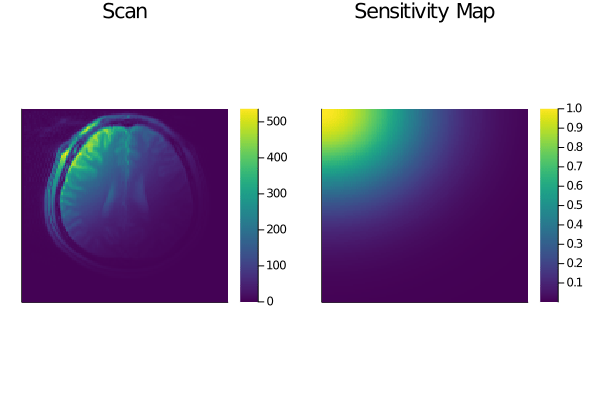

In [4]:
# View scans from each coil
scans_animation = @animate for coil in 1:numCoils
    plot(heatmap(coilScans[:,:,coil], c=:viridis, aspect_ratio=1),
         heatmap(coilSensitivityMaps[:,:,coil], c=:viridis, aspect_ratio=1),
         xlims=(0,size(coilScans,2)), ylims=(0,size(coilScans,1)), 
         yflip=true, axis=nothing, title=["Scan" "Sensitivity Map"])
end every 1
gif(scans_animation, "coilScans.gif", fps = 1)

### Create Sensitivity Maps

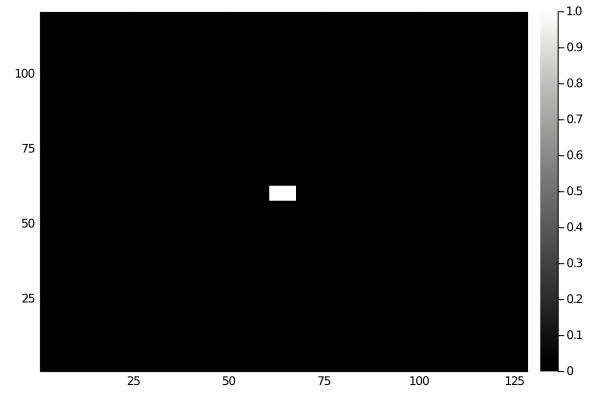

In [5]:
# Create mask to sample image
mask = zeros(Bool, (height, width)) # or rand
h_mid = convert(UInt16, round(height/2))
w_mid = convert(UInt16, round(width/2))
dy = convert(UInt16, round(height/50))
dx = convert(UInt16, round(width/50))
mask[h_mid-dy:h_mid+dy, w_mid-dx:w_mid+dx] .= 1
heatmap(mask, c=:grayscale)

┌ Info: Saved animation to 
│   fn = /home/sam/Documents/UniversityWork/CompressiveSensingForMagneticResonanceImaging/notebooks/SENSE/sensitivity_maps_comparison.gif
└ @ Plots /home/sam/.julia/packages/Plots/8GUYs/src/animation.jl:102


Plots.AnimatedGif("/home/sam/Documents/UniversityWork/CompressiveSensingForMagneticResonanceImaging/notebooks/SENSE/sensitivity_maps_comparison.gif")
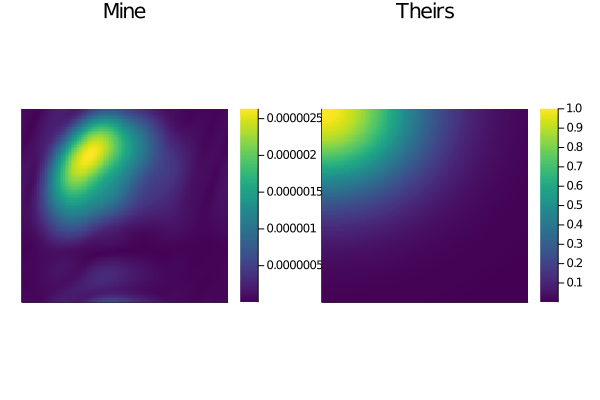

In [6]:
sensitivity_comparison_animation = @animate for coil in 1:numCoils
    kspace = fftshift(fft(coilScans[:,:,coil]))
    low_kspace = kspace .* mask
    sensitivity_map = ifft(ifftshift(low_kspace))
    sensitivity_map /= sum(sensitivity_map.^2)
    
    plot(heatmap(abs.(sensitivity_map), c=:viridis, aspect_ratio=1),
         heatmap(coilSensitivityMaps[:,:,coil], c=:viridis, aspect_ratio=1),
         xlims=(0,size(coilScans,2)), ylims=(0,size(coilScans,1)), 
         yflip=true, axis=nothing, title=["Mine" "Theirs"])
end every 1

gif(sensitivity_comparison_animation, "sensitivity_maps_comparison.gif", fps = 1)

### Reconstruction

In [7]:
recon = zeros(Float64, height, width)

for ix=1:width
    for iy=1:height
        y = reshape(coilScans[iy, ix, :], numCoils, 1)
        S = reshape(coilSensitivityMaps[iy, ix, :], numCoils, 1)

        recon[iy, ix] = (pinv(S) * y)[1]
    end
end

### Comparison

In [8]:
# Create comparison by Root Sum of Squares Method (RSOS)
original = sqrt.(sum(coilScans.^2, dims=3)[:,:]);

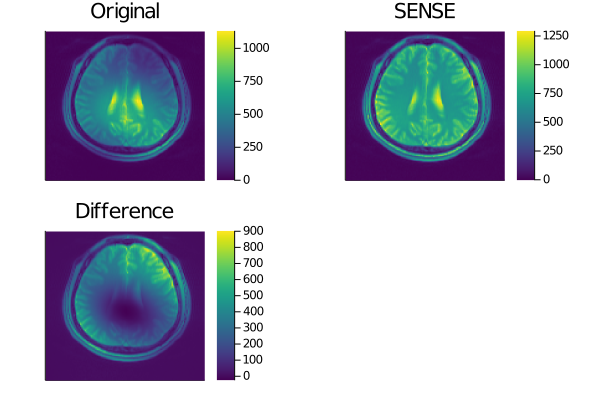

In [10]:
plot(heatmap(original, c=:viridis, aspect_ratio=1), 
     heatmap(recon, c=:viridis, aspect_ratio=1),
     heatmap(recon.-original, c=:viridis, aspect_ratio=1),
    xlims=(0,size(coilScans,2)), ylims=(0,size(coilScans,1)), 
    yflip=true, axis=nothing, title=["Original" "SENSE" "Difference"])